Importar módulos

In [3]:
import pandas as pd
import numpy as np
import pickle


Cargas los datos y pasarlos a pd.dataframe

In [4]:
# --- 1. Cargar el archivo PKL y convertir a DataFrame ---
DATASET_PATH  = 'jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000000_shuffled.pkl'
with open(DATASET_PATH, 'rb') as f:
    data = pickle.load(f)

# Si el objeto es una tupla, extraer sus elementos y convertirlos a listas (si son numpy.ndarray)
if isinstance(data, tuple):
    imagenes, objetivos = data
    if isinstance(imagenes, np.ndarray):
        imagenes = list(imagenes)
    if isinstance(objetivos, np.ndarray):
        objetivos = list(objetivos)
    
    # Crear un DataFrame con dos columnas: 'imagen' y 'objetivos'
    df = pd.DataFrame({
        'imagen': imagenes,
        'objetivos': objetivos
    })
else:
    df = data

Comprobar tipo de datos de los parámetros de la tupla

In [5]:
# Asegurar que los valores en objetivos son del tipo correcto
df['objetivos'] = df['objetivos'].apply(lambda x: [str(x[0]), float(x[1]), float(x[2])])


Suavizar escala de píxeles

In [6]:
# Hallar el máximo de cada imagen
'''
max_por_imagen = df['imagen'].apply(lambda img: np.max(img))
max_brillo_imagen = max_por_imagen.max()
'''

"\nmax_por_imagen = df['imagen'].apply(lambda img: np.max(img))\nmax_brillo_imagen = max_por_imagen.max()\n"

In [7]:
'''
def normalizar_imagen(img, max_val):
    # Combertir a float para evitar truncamientos
    img = img.astype(float)
    return img/max_val
    '''

'\ndef normalizar_imagen(img, max_val):\n    # Combertir a float para evitar truncamientos\n    img = img.astype(float)\n    return img/max_val\n    '

In [8]:
'''
for max_de_cada_imagen in max_por_imagen:
    df['imagen'].apply(lambda img: normalizar_imagen(img, max_de_cada_imagen))
'''

"\nfor max_de_cada_imagen in max_por_imagen:\n    df['imagen'].apply(lambda img: normalizar_imagen(img, max_de_cada_imagen))\n"

Estudiar distribuciones de [E, alpha, Q_0]

In [9]:
# Separamos la tupla en columnas: E, a, Q
df[['E','a','Q']] = pd.DataFrame(df['objetivos'].tolist(), index=df.index)

# Convertir la variable E de strings a {0,1}
df['E'] = df['E'].map({'MLBT': 0, 'MMAT': 1})

# Convertir 'a' de {0.2, 0.3, 0.4} a {0,1,2}
df['a'] = df['a'].map({0.2: 0, 0.3: 1, 0.4: 2})

# Convertir 'Q' de {1.0, 1.5, 2.0, 2.5} a {0,1,2,3}
df['Q'] = df['Q'].map({1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3})

# Si ya no deseas mantener df['values'], la puedes quitar
df.drop(columns=['objetivos'], inplace=True)

In [10]:
'''
#import matplotlib.pyplot as plt

# Distribución de E
df['E'].value_counts().plot(kind='bar')
plt.title("Distribución de E")
plt.xlabel("Valor de E")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de alpha
df['a'].value_counts().plot(kind='bar')
plt.title("Distribución de a")
plt.xlabel("Valor de a")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de Q
df['Q'].value_counts().plot(kind='bar')
plt.title("Distribución de Q")
plt.xlabel("Valor de Q")
plt.ylabel("Frecuencia")
plt.show()
'''


'\n#import matplotlib.pyplot as plt\n\n# Distribución de E\ndf[\'E\'].value_counts().plot(kind=\'bar\')\nplt.title("Distribución de E")\nplt.xlabel("Valor de E")\nplt.ylabel("Frecuencia")\nplt.show()\n\n# Distribución de alpha\ndf[\'a\'].value_counts().plot(kind=\'bar\')\nplt.title("Distribución de a")\nplt.xlabel("Valor de a")\nplt.ylabel("Frecuencia")\nplt.show()\n\n# Distribución de Q\ndf[\'Q\'].value_counts().plot(kind=\'bar\')\nplt.title("Distribución de Q")\nplt.xlabel("Valor de Q")\nplt.ylabel("Frecuencia")\nplt.show()\n'

In [11]:
#50/3

El valor de Q = 1.0 aparece en un 50% de los datos y el resto 16.666%

# El Modelo CNN

Preparar dataframe y dataloader

In [12]:
#df[['E','a','Q']] = pd.DataFrame(df['objetivos'].tolist(), index=df.index)
#df.drop(columns=['objetivos'], inplace=True)  # opcional, si ya no la necesitamos

In [13]:
# Conviertes la serie de imágenes a un array
X = np.stack(df["imagen"].values)  # shape -> (num_samples, 32, 32)
# Añadimos el canal extra para "grayscale = 1"
X = X[..., np.newaxis]            # shape -> (num_samples, 32, 32, 1)
#X = X/max_brillo_imagen

# Las etiquetas en forma de array
E = df["E"].values  # (num_samples,)
a = df["a"].values
Q = df["Q"].values

Dividir en train, test y validacion

In [14]:
from sklearn.model_selection import train_test_split

# Creamos un label unificado para estratificar
#label_unificado = E*12 + a*4 + Q  # e*g(12) + a*g(4) + Q

X_train, X_test, E_train, E_test, a_train, a_test, Q_train, Q_test = train_test_split(
    X, E, a, Q,
    test_size=0.2,
    random_state=42
)

In [15]:
##############################################################################
# 4. Definición del modelo CNN Multi-salida en Keras
##############################################################################

from sklearn.model_selection import train_test_split

# Librerías de Keras/TensorFlow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix


# Creamos una CNN sencilla con dos capas convolucionales, y luego 3 salidas:
#  - Salida para E (2 clases)
#  - Salida para a (3 clases)
#  - Salida para Q (4 clases)

inputs = keras.Input(shape=(32, 32, 1))

# Capa conv 1
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Capa conv 2
x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)


# Aplanar
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Tres salidas
output_E = layers.Dense(2, activation='softmax', name='E_output')(x)
output_a = layers.Dense(3, activation='softmax', name='a_output')(x)
output_Q = layers.Dense(4, activation='softmax', name='Q_output')(x)

model = keras.Model(inputs=inputs, outputs=[output_E, output_a, output_Q])

# Compilamos con pérdidas específicas (cada salida es sparse_categorical)
model.compile(
    optimizer='Adam',
    loss={
        'E_output': 'sparse_categorical_crossentropy',
        'a_output': 'sparse_categorical_crossentropy',
        'Q_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'E_output': 'accuracy',
        'a_output': 'accuracy',
        'Q_output': 'accuracy'
    }
)

model.summary()
'''
##############################################################################
# 5. Definir class_weight para la salida Q (opcional)
##############################################################################
# Como sabemos que Q=0 es 50% y Q=1,2,3 es ~16.6%, podríamos penalizar más
# a las clases minoritarias. Ajusta estos valores según la magnitud
# del desbalance que tengas.
class_weight_Q = {
    0: 1.0,  # la clase mayoritaria
    1: 3.0,  # las minoritarias
    2: 3.0,
    3: 3.0
}

# Para E (0,1) y a (0,1,2) dijiste que son equifrecuentes, así que puedes dejarlos en 1.0
class_weight_E = {0:1.0, 1:1.0}
class_weight_a = {0:1.0, 1:1.0, 2:1.0}


# Keras permite pasar un dict anidado:
# { 'nombre_salida': {clase: peso, ...}, ... }
class_weights_dict = {
    'E_output': class_weight_E,
    'a_output': class_weight_a,
    'Q_output': class_weight_Q
}
'''
##############################################################################
# 6. Entrenar el modelo con los datos de entrenamiento
##############################################################################
history = model.fit(
    X_train,
    [E_train, a_train, Q_train],  # Las 3 salidas
    validation_split=0.2,         # Ej. 20% de train para validación
    epochs=10,
    batch_size=128
    #class_weight=class_weights_dict  # Aplicamos los pesos
)



2025-02-07 00:55:10.234235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 00:55:10.340964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738889710.385524   84089 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738889710.398104   84089 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-07 00:55:10.497176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E_output (Dense)    │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_output (Dense)    │ (None, 3)         │        387 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q_output (Dense)    │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 544,393 (2.08 MB)

 Trainable params: 544,393 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 120s 24ms/step - E_output_accuracy: 0.8353 - E_output_loss: 0.3631 - Q_output_accuracy: 0.5942 - Q_output_loss: 0.9128 - a_output_accuracy: 0.4821 - a_output_loss: 0.9919 - loss: 2.2678 - val_E_output_accuracy: 0.9116 - val_E_output_loss: 0.2306 - val_Q_output_accuracy: 0.6289 - val_Q_output_loss: 0.7786 - val_a_output_accuracy: 0.5176 - val_a_output_loss: 0.9459 - val_loss: 1.9552
Epoch 2/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - E_output_accuracy: 0.9052 - E_output_loss: 0.2429 - Q_output_accuracy: 0.6254 - Q_output_loss: 0.7904 - a_output_accuracy: 0.5116 - a_output_loss: 0.9499 - loss: 1.9832 - val_E_output_accuracy: 0.9008 - val_E_output_loss: 0.2488 - val_Q_output_accuracy: 0.6273 - val_Q_output_loss: 0.7999 - val_a_output_accuracy: 0.5179 - val_a_output_loss: 0.9458 - val_loss: 1.9945
Epoch 3/10
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - E_output_accuracy: 0.9118 - E_output_loss: 0.2270 - Q_output_accuracy: 0.6305 - Q_outpu

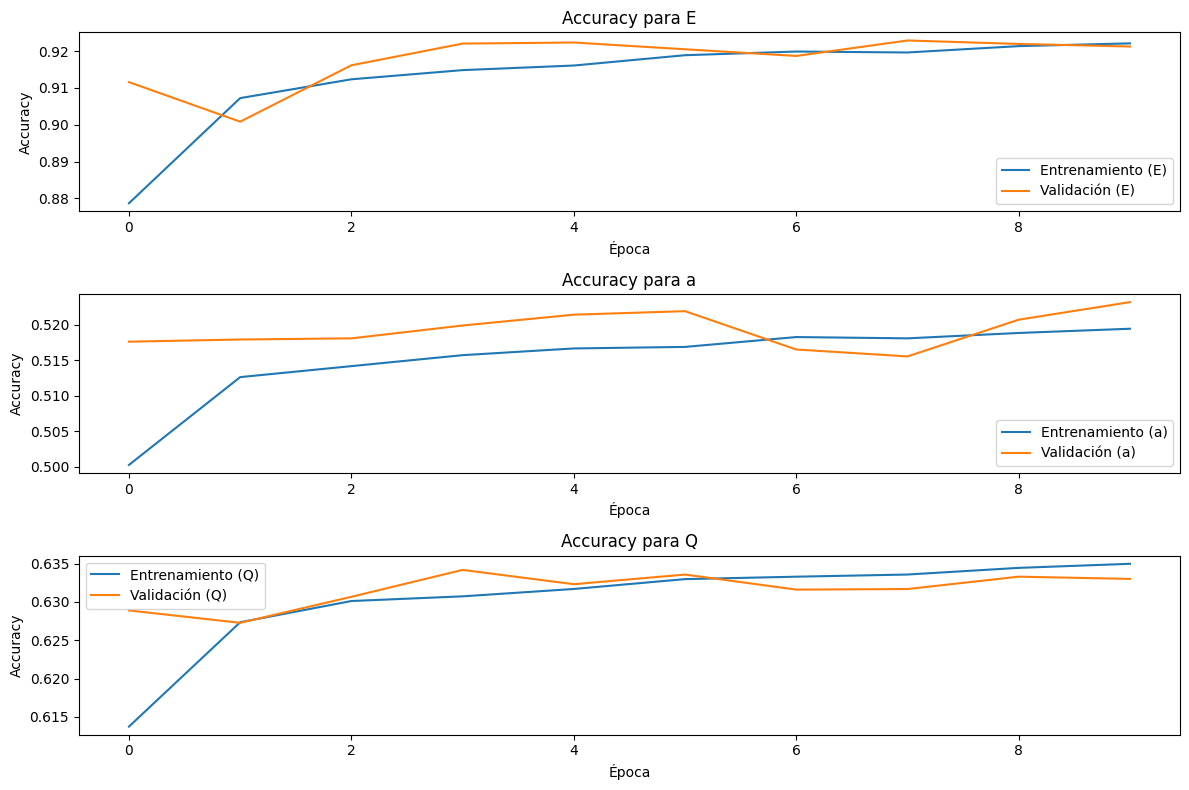

Métricas en test (orden: total_loss, E_loss, E_acc, a_loss, a_acc, Q_loss, Q_acc):
[1.9060273170471191, 0.21077685058116913, 0.9390271306037903, 0.756226658821106, 0.9203100204467773, 0.6325500011444092, 0.5199400186538696]
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
Accuracy E: 0.920
Accuracy a: 0.520
Accuracy Q: 0.633
Exact match accuracy (E, a, Q): 0.289


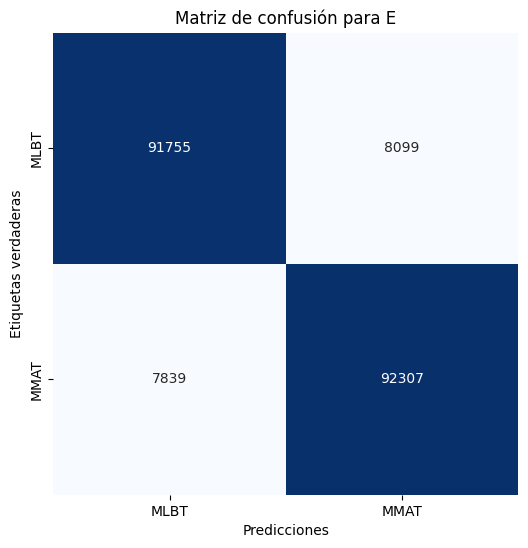

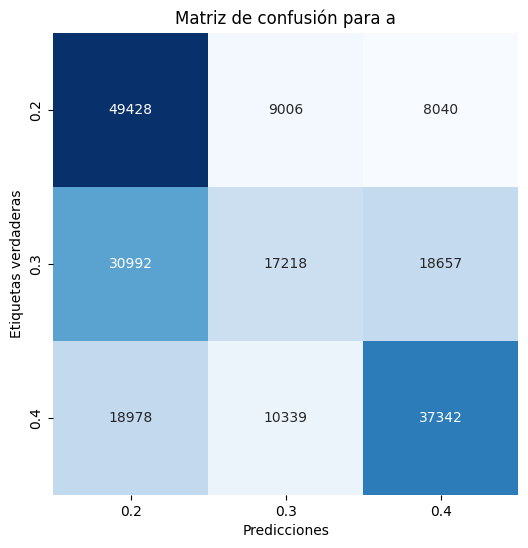

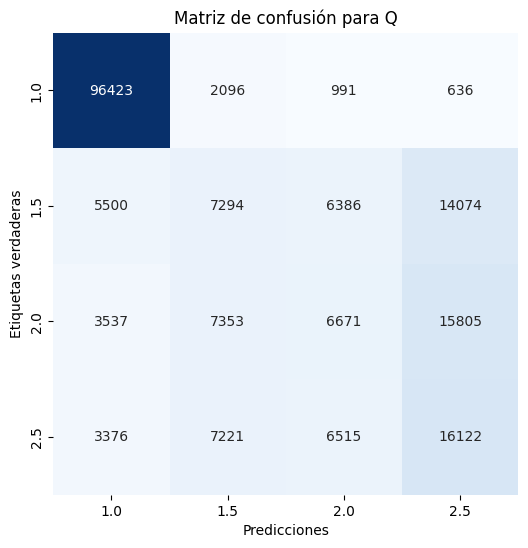

El modelo ha sido guardado como 'modelo_keras.h5'.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# Graficar la evolución del accuracy para cada salida (E, a, Q)
plt.figure(figsize=(12, 8))

# Accuracy para E
plt.subplot(3, 1, 1)
plt.plot(history.history['E_output_accuracy'], label='Entrenamiento (E)')
plt.plot(history.history['val_E_output_accuracy'], label='Validación (E)')
plt.title('Accuracy para E')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Accuracy para a
plt.subplot(3, 1, 2)
plt.plot(history.history['a_output_accuracy'], label='Entrenamiento (a)')
plt.plot(history.history['val_a_output_accuracy'], label='Validación (a)')
plt.title('Accuracy para a')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Accuracy para Q
plt.subplot(3, 1, 3)
plt.plot(history.history['Q_output_accuracy'], label='Entrenamiento (Q)')
plt.plot(history.history['val_Q_output_accuracy'], label='Validación (Q)')
plt.title('Accuracy para Q')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##############################################################################
# 7. Evaluar el modelo en test
##############################################################################
# model.evaluate devuelve [loss_total, E_loss, E_acc, a_loss, a_acc, Q_loss, Q_acc]
test_metrics = model.evaluate(X_test, [E_test, a_test, Q_test], verbose=0)
print("Métricas en test (orden: total_loss, E_loss, E_acc, a_loss, a_acc, Q_loss, Q_acc):")
print(test_metrics)

# También podemos predecir y calcular accuracy manualmente
E_pred_proba, a_pred_proba, Q_pred_proba = model.predict(X_test)
E_pred = E_pred_proba.argmax(axis=1)
a_pred = a_pred_proba.argmax(axis=1)
Q_pred = Q_pred_proba.argmax(axis=1)

acc_E = np.mean(E_pred == E_test)
acc_a = np.mean(a_pred == a_test)
acc_Q = np.mean(Q_pred == Q_test)

print(f"Accuracy E: {acc_E:.3f}")
print(f"Accuracy a: {acc_a:.3f}")
print(f"Accuracy Q: {acc_Q:.3f}")

# Calcular el exact match (todas las predicciones correctas al mismo tiempo)
exact_match = np.mean((E_pred == E_test) & (a_pred == a_test) & (Q_pred == Q_test))

print(f"Exact match accuracy (E, a, Q): {exact_match:.3f}")

# Crear etiquetas compuestas para las etiquetas verdaderas
true_labels = list(zip(E_test, a_test, Q_test))

# Crear etiquetas compuestas para las predicciones
pred_labels = list(zip(E_pred, a_pred, Q_pred))

def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(6, 6))  # Ajusta el tamaño de la figura
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas verdaderas')
    plt.show()

# Nombres de las clases para E, a y Q
class_names_E = ['MLBT', 'MMAT']  # Ejemplo para E
class_names_a = ['0.2', '0.3', '0.4']  # Ejemplo para a
class_names_Q = ['1.0', '1.5', '2.0', '2.5']  # Ejemplo para Q

# Calcular las matrices de confusión
conf_matrix_E = confusion_matrix(E_test, E_pred)
conf_matrix_a = confusion_matrix(a_test, a_pred)
conf_matrix_Q = confusion_matrix(Q_test, Q_pred)

# Graficar las matrices de confusión
plot_confusion_matrix(conf_matrix_E, class_names_E, "Matriz de confusión para E")
plot_confusion_matrix(conf_matrix_a, class_names_a, "Matriz de confusión para a")
plot_confusion_matrix(conf_matrix_Q, class_names_Q, "Matriz de confusión para Q")



# Guardar el modelo en el archivo "modelo_keras.h5"
model.save('modelo_keras.h5')
print("El modelo ha sido guardado como 'modelo_keras.h5'.")

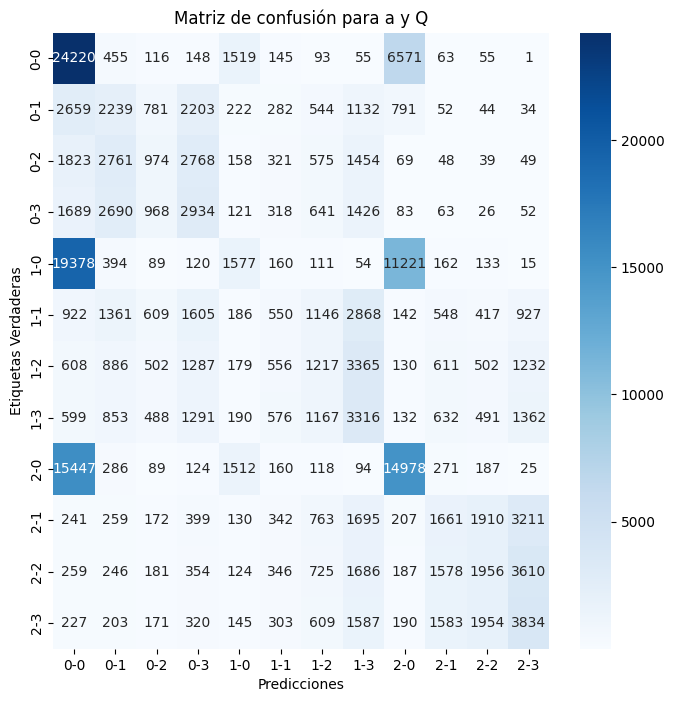

In [19]:
from sklearn.metrics import classification_report
# Crear etiquetas combinadas solo para a y Q
def encode_a_Q(a, Q):
    return f"{a}-{Q}"  # Convierte cada combinación en un string

true_labels_aQ = [encode_a_Q(a, q) for a, q in zip(a_test, Q_test)]
pred_labels_aQ = [encode_a_Q(a, q) for a, q in zip(a_pred, Q_pred)]

# Obtener la matriz de confusión
conf_matrix_aQ = confusion_matrix(true_labels_aQ, pred_labels_aQ)

# Nombres de las clases
unique_labels_aQ = sorted(set(true_labels_aQ + pred_labels_aQ))

# Graficar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_aQ, annot=True, fmt="d", cmap="Blues",
            xticklabels=unique_labels_aQ, yticklabels=unique_labels_aQ)
plt.xlabel("Predicciones")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de confusión para a y Q")
plt.show()

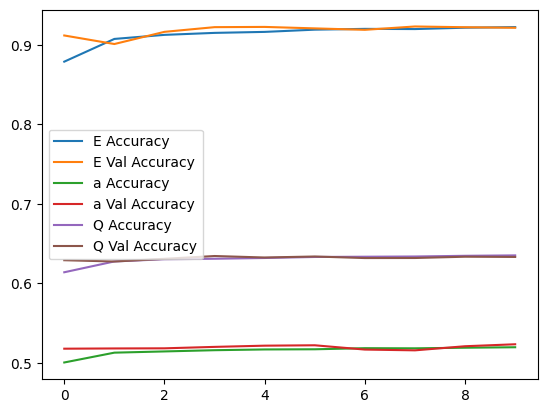

In [22]:
plt.plot(history.history['E_output_accuracy'], label='E Accuracy')
plt.plot(history.history['val_E_output_accuracy'], label='E Val Accuracy')
plt.plot(history.history['a_output_accuracy'], label='a Accuracy')
plt.plot(history.history['val_a_output_accuracy'], label='a Val Accuracy')
plt.plot(history.history['Q_output_accuracy'], label='Q Accuracy')
plt.plot(history.history['val_Q_output_accuracy'], label='Q Val Accuracy')
plt.legend()
plt.show()